In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Gpu info:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Sep  6 16:20:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generator.py

In [ ]:
"""
@description:
This is used for augmentation on-the-fly.
"""

import numpy as np
import re
from scipy import linalg
import scipy.ndimage as ndi
# from six.moves import range
import os
import threading
import matplotlib.pyplot as plt
from keras import backend as K
from tensorflow.keras import layers
#from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
def random_channel_shift(x, intensity, channel_index=0):
    x = np.rollaxis(x, channel_index, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_channel + np.random.uniform(-intensity, intensity), min_x, max_x)
                      for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


def apply_transform(x, transform_matrix, channel_index=0, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x


def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x


def array_to_img(x, dim_ordering='default', scale=True):
    from PIL import Image
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    if dim_ordering == 'th':
        x = x.transpose(1, 2, 0)
    if scale:
        x += max(-np.min(x), 0)
        x /= np.max(x)
        x *= 255
    if x.shape[2] == 3:
        # RGB
        return Image.fromarray(x.astype('uint8'), 'RGB')
    elif x.shape[2] == 1:
        # grayscale
        return Image.fromarray(x[:, :, 0].astype('uint8'), 'L')
    else:
        raise Exception('Unsupported channel number: ', x.shape[2])


def img_to_array(img, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    if dim_ordering not in ['th', 'tf']:
        raise Exception('Unknown dim_ordering: ', dim_ordering)
    # image has dim_ordering (height, width, channel)
    x = np.asarray(img, dtype='float32')
    if len(x.shape) == 3:
        if dim_ordering == 'th':
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if dim_ordering == 'th':
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise Exception('Unsupported image shape: ', x.shape)
    return x


class ImageDataGenerator(object):
    '''
    Generate minibatches with
    real-time data augmentation.
    Assume X is train img, Y is train label (same size as X with only 0 and 255 for values)
    # Arguments
        featurewise_center: set input mean to 0 over the dataset. Only to X
        samplewise_center: set each sample mean to 0. Only to X
        featurewise_std_normalization: divide inputs by std of the dataset. Only to X
        samplewise_std_normalization: divide each input by its std. Only to X
        zca_whitening: apply ZCA whitening. Only to X
        rotation_range: degrees (0 to 180). To X and Y
        width_shift_range: fraction of total width. To X and Y
        height_shift_range: fraction of total height. To X and Y
        shear_range: shear intensity (shear angle in radians). To X and Y
        zoom_range: amount of zoom. if scalar z, zoom will be randomly picked
            in the range [1-z, 1+z]. A sequence of two can be passed instead
            to select this range. To X and Y
        channel_shift_range: shift range for each channels. Only to X
        fill_mode: points outside the boundaries are filled according to the
            given mode ('constant', 'nearest', 'reflect' or 'wrap'). Default
            is 'nearest'. For Y, always fill with constant 0
        cval: value used for points outside the boundaries when fill_mode is
            'constant'. Default is 0.
        horizontal_flip: whether to randomly flip images horizontally. To X and Y
        vertical_flip: whether to randomly flip images vertically. To X and Y
        rescale: rescaling factor. If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided (before applying
            any other transformation). Only to X
        dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension
            (the depth) is at index 1, in 'tf' mode it is at index 3.
            It defaults to the `image_dim_ordering` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "th".
    '''
    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 rotation_range=0.,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 dim_ordering='default'
                 ):
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.__dict__.update(locals())
        self.mean = None
        self.std = None
        self.principal_components = None
        self.rescale = rescale

        if dim_ordering not in {'tf', 'th'}:
            raise Exception('dim_ordering should be "tf" (channel after row and '
                            'column) or "th" (channel before row and column). '
                            'Received arg: ', dim_ordering)
        self.dim_ordering = dim_ordering
        if dim_ordering == 'th':
            self.channel_index = 1
            self.row_index = 2
            self.col_index = 3
        if dim_ordering == 'tf':
            self.channel_index = 3
            self.row_index = 1
            self.col_index = 2

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise Exception('zoom_range should be a float or '
                            'a tuple or list of two floats. '
                            'Received arg: ', zoom_range)

    def flow(self, X, y=None, batch_size=32, shuffle=True, seed=None,
             save_to_dir=None, save_prefix='', save_format='jpeg'):
        return NumpyArrayIterator(
            X, y, self,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            dim_ordering=self.dim_ordering,
            save_to_dir=save_to_dir, save_prefix=save_prefix, save_format=save_format)

    def standardize(self, x):
        # Only applied to X
        if self.rescale:
            x *= self.rescale
        # x is a single image, so it doesn't have image number at index 0
        img_channel_index = self.channel_index - 1
        if self.samplewise_center:
            x -= np.mean(x, axis=img_channel_index, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, axis=img_channel_index, keepdims=True) + 1e-7)

        if self.featurewise_center:
            x -= self.mean
        if self.featurewise_std_normalization:
            x /= (self.std + 1e-7)

        if self.zca_whitening:
            flatx = np.reshape(x, (x.size))
            whitex = np.dot(flatx, self.principal_components)
            x = np.reshape(whitex, (x.shape[0], x.shape[1], x.shape[2]))

        return x

    def random_transform(self, x, y):
        # Need to modify to transform both X and Y ---- to do
        # x is a single image, so it doesn't have image number at index 0
        img_row_index = self.row_index - 1
        img_col_index = self.col_index - 1
        img_channel_index = self.channel_index - 1

        # use composition of homographies to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                    [np.sin(theta), np.cos(theta), 0],
                                    [0, 0, 1]])
        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_index]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_index]
        else:
            ty = 0

        translation_matrix = np.array([[1, 0, tx],
                                       [0, 1, ty],
                                       [0, 0, 1]])
        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0
        shear_matrix = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(self.zoom_range[0], self.zoom_range[1], 2)
        zoom_matrix = np.array([[zx, 0, 0],
                                [0, zy, 0],
                                [0, 0, 1]])

        transform_matrix = np.dot(np.dot(np.dot(rotation_matrix, translation_matrix), shear_matrix), zoom_matrix)

        h, w = x.shape[img_row_index], x.shape[img_col_index]
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        x = apply_transform(x, transform_matrix, img_channel_index,
                            fill_mode=self.fill_mode, cval=self.cval)
        # For y, mask data, fill mode constant, cval = 0
        y = apply_transform(y, transform_matrix, img_channel_index,
                            fill_mode=self.fill_mode, cval= self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x, self.channel_shift_range, img_channel_index)

        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_index)
                y = flip_axis(y, img_col_index)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_index)
                y = flip_axis(y, img_row_index)

        # TODO:
        # channel-wise normalization
        # barrel/fisheye
        return x, y

    def fit(self, X,
            augment=False,
            rounds=1,
            seed=None):
        '''
        Required for featurewise_center, featurewise_std_normalization
        and zca_whitening.
       
        # Arguments
            X: Numpy array, the data to fit on.
            augment: whether to fit on randomly augmented samples
            rounds: if `augment`,
                how many augmentation passes to do over the data
            seed: random seed.
        # Only applied to X
        '''
        X = np.copy(X)
        if augment:
            aX = np.zeros(tuple([rounds * X.shape[0]] + list(X.shape)[1:]))
            for r in range(rounds):
                for i in range(X.shape[0]):
                    aX[i + r * X.shape[0]] = self.random_transform(X[i])
            X = aX

        if self.featurewise_center:
            self.mean = np.mean(X, axis=0)
            X -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(X, axis=0)
            X /= (self.std + 1e-7)

        if self.zca_whitening:
            flatX = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))
            sigma = np.dot(flatX.T, flatX) / flatX.shape[1]
            U, S, V = linalg.svd(sigma)
            self.principal_components = np.dot(np.dot(U, np.diag(1. / np.sqrt(S + 10e-7))), U.T)


class Iterator(object):

    def __init__(self, N, batch_size, shuffle, seed):
        self.N = N
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(N, batch_size, shuffle, seed)

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, N, batch_size=32, shuffle=False, seed=None):
        # ensure self.batch_index is 0
        self.reset()
        while 1:
            if self.batch_index == 0:
                index_array = np.arange(N)
                if shuffle:
                    if seed is not None:
                        np.random.seed(seed + self.total_batches_seen)
                    index_array = np.random.permutation(N)

            current_index = (self.batch_index * batch_size) % N
            if N >= current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = N - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        # ?
        return self.next(*args, **kwargs)


class NumpyArrayIterator(Iterator):

    def __init__(self, X, y, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 dim_ordering='default',
                 save_to_dir=None, save_prefix='', save_format='jpeg'):
        if len(X) != len(y):
            raise Exception('X (images tensor) and y (labels) '
                            'should have the same length. '
                            'Found: X.shape = %s, y.shape = %s' % (np.asarray(X).shape, np.asarray(y).shape))
        if dim_ordering == 'default':
            dim_ordering = K.image_dim_ordering()
        self.X = X
        self.y = y
        self.image_data_generator = image_data_generator
        self.dim_ordering = dim_ordering
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format
        super(NumpyArrayIterator, self).__init__(X.shape[0], batch_size, shuffle, seed)

    def next(self):
        # for python 2.x.
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch
        # see http://anandology.com/blog/using-iterators-and-generators/
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + list(self.X.shape)[1:]))
        batch_y = np.zeros(tuple([current_batch_size] + list(self.y.shape)[1:]))
        for i, j in enumerate(index_array):
            x = self.X[j]
            label = self.y[j]
            x, label = self.image_data_generator.random_transform(x.astype('float32'), label.astype('float32'))
            x = self.image_data_generator.standardize(x)
            batch_x[i] = x
            batch_y[i] = label
        if self.save_to_dir:
            for i in range(current_batch_size):
                img = array_to_img(batch_x[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
                mask = array_to_img(batch_y[i], self.dim_ordering, scale=True)
                fname = '{prefix}_{index}_{hash}_mask.{format}'.format(prefix=self.save_prefix,
                                                                  index=current_index + i,
                                                                  hash=np.random.randint(1e4),
                                                                  format=self.save_format)
                mask.save(os.path.join(self.save_to_dir, fname))
        return batch_x, batch_y

## Model.py

In [ ]:
"""
@description: 
This is the file to create the model, similar as the paper, 
but with batch normalization,
make it more easier to train.

U-net version is also provided.
"""

from __future__ import absolute_import
from __future__ import print_function
import numpy as np
from keras import backend as K
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Conv1D, Conv2D, AveragePooling2D, AveragePooling1D, Flatten, MaxPooling2D, MaxPooling1D, Dropout, BatchNormalization, Concatenate, concatenate, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu
#from keras.utils import Sequence
from tensorflow.keras.utils import Sequence
"""
from keras.layers import (
    Input,
    Activation,
    Concatenate,
    concatenate,
    Dropout,
    Reshape,
    Permute,
    Dense,
    UpSampling2D,
    Flatten
    )
from keras.layers.convolutional import (
    Convolution2D)
from keras.layers.pooling import (
    MaxPooling2D,
    AveragePooling2D
    )
"""
from tensorflow.keras.optimizers import SGD, RMSprop
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.regularizers import l2

In [ ]:
weight_decay = 1e-5
#K.set_image_dim_ordering('tf')
#K.image_data_format('tf')

In [ ]:
def _conv_bn_relu(nb_filter, row, col, strides = (1,1)):
    def f(input):
        conv_a = Conv2D(nb_filter, (row, col), strides = strides,
                               kernel_initializer = 'orthogonal', 
                               padding='same', use_bias = False)(input)
        norm_a = BatchNormalization()(conv_a)
        act_a = relu(norm_a)
        return act_a
    return f

In [ ]:
def _conv_bn_relu_x2(nb_filter, row, col, strides = (1,1)):
    def f(input):
        conv_a = Conv2D(nb_filter, (row, col), strides = strides,
                               kernel_initializer = 'orthogonal', padding = 'same',use_bias = False,
                               kernel_regularizer = l2(weight_decay),
                               bias_regularizer = l2(weight_decay))(input)
        norm_a = BatchNormalization()(conv_a)
        act_a = relu(norm_a)
        conv_b = Conv2D(nb_filter, (row, col), strides = strides,
                               kernel_initializer = 'orthogonal', padding = 'same',use_bias = False,
                               kernel_regularizer = l2(weight_decay),
                               bias_regularizer = l2(weight_decay))(act_a)
        norm_b = BatchNormalization()(conv_b)
        act_b = relu(norm_b)
        return act_b
    return f

In [ ]:
def U_net_base(input, nb_filter = 64):
    block1 = _conv_bn_relu_x2(nb_filter,5,5)(input)
    pool1 = MaxPooling2D(pool_size=(2,2))(block1)
    # =========================================================================
    block2 = _conv_bn_relu_x2(nb_filter,3,3)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(block2)
    # =========================================================================
    block3 = _conv_bn_relu_x2(nb_filter,3,3)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(block3)
    # =========================================================================
    block4 = _conv_bn_relu_x2(nb_filter,3,3)(pool3)
    up4 = concatenate([UpSampling2D(size=(2, 2))(block4), block3], axis=-1)
    # =========================================================================
    block5 = _conv_bn_relu_x2(nb_filter,3,3)(up4)
    up5 = concatenate([UpSampling2D(size=(2, 2))(block5), block2], axis=-1)
    # =========================================================================
    block6 = _conv_bn_relu_x2(nb_filter,5,5)(up5)
    up6 = concatenate([UpSampling2D(size=(2, 2))(block6), block1], axis=-1)
    # =========================================================================
    block7 = _conv_bn_relu(nb_filter,3,3)(up6)
    return block7

In [ ]:
def buildModel_U_net (input_dim):
    input_ = Input(shape = (input_dim))
    # =========================================================================
    act_ = U_net_base (input_, nb_filter = 64 )
    # =========================================================================
    density_pred =  Conv2D(1, (1, 1), use_bias = False, activation='linear',\
                                  kernel_initializer='orthogonal',name='pred',padding='same')(act_)
    # =========================================================================
    model = Model(inputs = input_, outputs = density_pred)
    opt = RMSprop(1e-3)
    model.compile(optimizer = opt, loss = 'mse')
    return model

## Train.py

In [ ]:
"""
@Description: This is the file used for training, loading images, annotation, training with model.
"""
import numpy as np
import pdb
import os
import matplotlib.pyplot as plt
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from model import buildModel_U_net
from keras import backend as K
from keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler
from scipy import misc
import imageio
import scipy.ndimage as ndimage

In [ ]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

#base_path = 'cells/'
data = []
anno = []

def step_decay(epoch):
    step = 16
    num =  epoch // step 
    if num % 3 == 0:
        lrate = 1e-3
    elif num % 3 == 1:
        lrate = 1e-4
    else:
        lrate = 1e-5
        #lrate = initial_lrate * 1/(1 + decay * (epoch - num * step))
    print('Learning rate for epoch {} is {}.'.format(epoch+1, lrate))
    return np.float(lrate)

from PIL import Image 

def read_data(base_path):
    data = []
    anno = []
    imList = os.listdir(base_path)
    for i in range(len(imList)): 
        if 'Density' in imList[i]:
            img1 =  np.asarray(Image.open(os.path.join(base_path,imList[i][:-11] + '.tif')).convert("RGB"))
            data.append(img1)
            
            img2 = imageio.imread(os.path.join(base_path, imList[i]))
            anno.append(img2)
    return np.asarray(data), np.asarray(anno)

In [ ]:
def train_(base_path):
    data = []
    anno = []
    data, anno = read_data(base_path)
    anno = np.expand_dims(anno, axis = -1)
    
    mean = np.mean(data)
    std = np.std(data)

    data_ = (data - mean) / std

    train_data = data_[:142]
    train_anno = anno[:142]

    val_data = data_[142:]
    val_anno = anno[142:]
    
    print('-'*30)
    print('Creating and compiling the fully convolutional regression networks.')
    print('-'*30)    
   
    model = buildModel_U_net(input_dim = (256,256,3))
    model_checkpoint = ModelCheckpoint('cone_counting.hdf5', monitor='loss', save_best_only=True)
    model.summary()
    print('...Fitting model...')
    print('-'*30)
    change_lr = LearningRateScheduler(step_decay)

    datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
        zoom_range = 0.3,
        shear_range = 0.,
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True, # randomly flip images
        fill_mode = 'constant',
        dim_ordering = 'tf')  

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(train_data,
                                     train_anno,
                                     batch_size = 16
                                     ),
                        batch_size = 16, #train_data.shape[0],
                        steps_per_epoch = train_data.shape[0]//16,
                        epochs = 200,
                        callbacks = [model_checkpoint, change_lr],
                       )
    
    model.load_weights('cone_counting.hdf5')
    A = model.predict(val_data)
    mean_diff = np.average(np.abs(np.sum(np.sum(A,1),1)-np.sum(np.sum(val_anno,1),1))) / (100.0)
    print('After training, the difference is : {} cells per image.'.format(np.abs(mean_diff)))

# Training

In [ ]:
train_path = '/content/drive/My Drive/hes-so/data/machine1_5/Training+Density/'
test_path = '/content/drive/My Drive/hes-so/data/machine1_5/Validation+Density/'

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0, 
                           patience=20, 
                           verbose=1, 
                           mode='min',  
                           restore_best_weights=True)

In [ ]:
data = []
anno = []
def read_data(base_path):
    imList = os.listdir(base_path)
    for i in range(len(imList)): 
        if 'Density' in imList[i]:
            img1 =  np.asarray(Image.open(os.path.join(base_path,imList[i][:-11] + '.tif')).convert("RGB"))
            img2 = imageio.imread(os.path.join(base_path, imList[i]))
            if np.sum(np.sum(img2,0),0)/100 < 400:
              data.append(img1)
              anno.append(img2)
    return np.asarray(data), np.asarray(anno)

In [ ]:
data = []
anno = []
def read_data_test(base_path):
    imList = os.listdir(base_path)
    for i in range(len(imList)): 
        if 'Density' in imList[i]:
            img1 =  np.asarray(Image.open(os.path.join(base_path,imList[i][:-11] + '.tif')).convert("RGB"))
            img2 = imageio.imread(os.path.join(base_path, imList[i]))
            if np.sum(np.sum(img2,0),0)/100 < 1000:
              data.append(img1)
              anno.append(img2)
    return np.asarray(data), np.asarray(anno)

In [ ]:
data = []
anno = []
data, anno = read_data(train_path)
anno = np.expand_dims(anno, axis = -1)

mean = np.mean(data)
std = np.std(data)

data_ = (data - mean) / std
#data_ = data

In [ ]:
data.shape

(184, 256, 256, 3)

In [ ]:
idx = np.arange(184)
np.random.shuffle(idx)
data_ = data_[idx]
anno = anno[idx]

train_data = data_[:140]
train_anno = anno[:140]

val_data = data_[140:]
val_anno = anno[140:]

In [ ]:
cones = []
for i in range(184):
  if np.sum(np.sum(anno[i][:,:,0],0),0)/100 < 400:
    cones.append(np.sum(np.sum(anno[i][:,:,0],0),0)/100)

In [ ]:
np.mean(cones)

125.62499979433805

# This is Adam

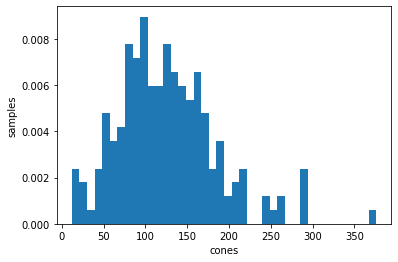

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


plt.hist(cones, density=True, bins=40)  # density=False would make counts
plt.ylabel('samples')
plt.xlabel('cones');

# This is Cunefare

In [ ]:
data = []
anno = []
data, anno = read_data_test(test_path)
anno = np.expand_dims(anno, axis = -1)

data_ = (data - mean) / std
#data_ = data

test_data = data_
test_anno = anno

In [ ]:
cones = []
for i in range(80):
  if np.sum(np.sum(anno[i][:,:,0],0),0)/100 < 400:
    cones.append(np.sum(np.sum(anno[i][:,:,0],0),0)/100)

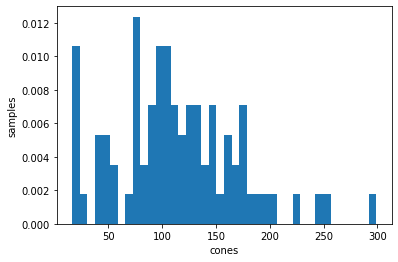

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


plt.hist(cones, density=True, bins=40)  # density=False would make counts
plt.ylabel('samples')
plt.xlabel('cones');

In [ ]:
train_data.shape

(140, 256, 256, 3)

In [ ]:
val_data.shape

(44, 256, 256, 3)

In [ ]:
test_data.shape

(80, 256, 256, 3)

In [ ]:
def get_model(img_size, num_classes):
    inputs = Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 5, padding="same")(x)# activation="relu")(x)

    outputs = BatchNormalization()(outputs)
    outputs = relu(outputs)

    outputs =  Conv2D(1, (1, 1), use_bias = False, activation='linear',\
                                  kernel_initializer='orthogonal',name='pred',padding='same')(outputs)

    # Define the model
    model = Model(inputs, outputs)
    return model

In [ ]:
model = get_model((256,256), 3)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#model = buildModel_U_net(input_dim = (256,256,3))
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/hes-so/baseline/weights/big_unet_cone_counting_adam.hdf5', monitor='val_loss', save_best_only=True, verbose = True)

In [ ]:
opt = RMSprop(1e-3)
model.compile(optimizer = opt, loss = 'mse')

In [ ]:
print('...Fitting model...')
print('-'*30)
change_lr = LearningRateScheduler(step_decay)

datagen = ImageDataGenerator(
    featurewise_center = False,  # set input mean to 0 over the dataset
    samplewise_center = False,  # set each sample mean to 0
    featurewise_std_normalization = False,  # divide inputs by std of the dataset
    samplewise_std_normalization = False,  # divide each input by its std
    zca_whitening = False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range = 0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range = 0.3,  # randomly shift images vertically (fraction of total height)
    zoom_range = 0.3,
    shear_range = 0.,
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True, # randomly flip images
    fill_mode = 'constant',
    dim_ordering = 'tf'
    )  

model.load_weights('/content/drive/My Drive/hes-so/baseline/weights/big_unet_cone_counting_cunefare.hdf5')


# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(train_data,
                                  train_anno,
                                  batch_size = 16
                                  ),
                    validation_data = (val_data, val_anno),
                    #validation_split=0.2,
                    batch_size = 16, #train_data.shape[0],
                    steps_per_epoch = train_data.shape[0]//16,
                    epochs = 200,
                    callbacks = [model_checkpoint, early_stop, change_lr],
                    )


...Fitting model...
------------------------------
Epoch 1/200
Learning rate for epoch 1 is 0.001.
8/8 [==============================] - 12s 500ms/step - loss: 1.0918 - val_loss: 1.3237

Epoch 00001: val_loss improved from inf to 1.32370, saving model to /content/drive/My Drive/hes-so/baseline/weights/big_unet_cone_counting_adam.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
Learning rate for epoch 2 is 0.001.
8/8 [==============================] - 4s 293ms/step - loss: 1.0906 - val_loss: 1.4097

Epoch 00002: val_loss did not improve from 1.32370
Epoch 3/200
Learning rate for epoch 3 is 0.001.
8/8 [==============================] - 2s 288ms/step - loss: 0.9852 - val_loss: 1.2373

Epoch 00003: val_loss improved from 1.32370 to 1.23732, saving model to /content/drive/My Drive/hes-so/baseline/weights/big_unet_cone_counting_adam.hdf5
Epoch 4/200
Learning rate for epoch 4 is 0.001.
8/8 [==============================] - 2s 292ms/step - loss: 1.0766 - val_loss: 1.2183

Epoch 00004: val_loss improved from 1.23732 to 1.21828, saving model to /content/drive/My Drive/hes-so/baseline/weights/big_unet_cone_counting_adam.hdf5
Epoch 5/200
Learning rate for epoch 5 is 0.001.
8/8 [==============================] - 2s 290ms/step - loss: 1.0117 - val_loss: 1.2216

Epoch 00005: val_loss did not improve from 1.21828
Epoch 6/200
Learning rate for epoch 6 is 0.001.


In [ ]:
model.load_weights('/content/drive/My Drive/hes-so/baseline/weights/big_unet_cone_counting_adam.hdf5')
A = model.predict(test_data)
mean_diff = np.average(np.abs(np.sum(np.sum(A,1),1)-np.sum(np.sum(test_anno,1),1))) / (100.0)
print('After training, the difference is : {} cells per image.'.format(np.abs(mean_diff)))

After training, the difference is : 13.85034423828125 cells per image.


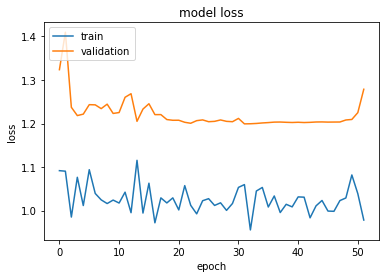

In [ ]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
pred = np.sum(np.sum(A,1),1)
true = np.sum(np.sum(test_anno,1),1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


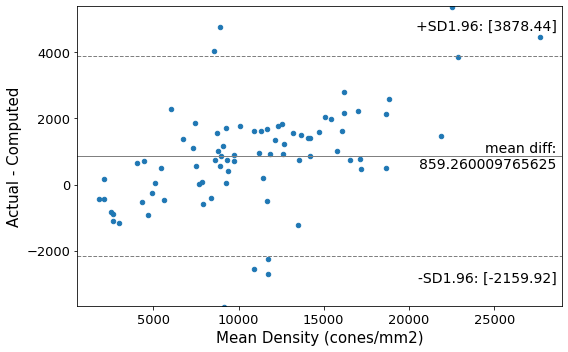

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(true, pred, ax = ax)
plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

In [ ]:
import pandas as pd
dataframe = pd.DataFrame(np.reshape(np.transpose(np.asarray([true, pred])), (80,2)), columns = ['True', 'Pred'])

In [ ]:
dataframe.to_csv('diferencias_adam.csv')

In [ ]:
max, min = np.argmax(np.abs(true-pred)), np.argmin(np.abs(true-pred))

In [ ]:
diferencias = np.abs(true-pred)

In [ ]:
diferencias.mean()

1385.0344

(array([3.72454253e-04, 2.79340690e-04, 9.31135526e-05, 8.38022164e-04,
        3.72454210e-04, 6.51794868e-04, 7.44908421e-04, 2.79340785e-04,
        3.72454041e-04, 2.79340785e-04, 3.72454380e-04, 4.65567551e-04,
        4.65567975e-04, 2.79340531e-04, 9.31135949e-05, 1.86227190e-04,
        3.72454380e-04, 0.00000000e+00, 9.31135949e-05, 9.31135949e-05,
        1.86227190e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.31134256e-05,
        9.31135949e-05, 0.00000000e+00, 9.31135949e-05, 0.00000000e+00,
        0.00000000e+00, 9.31135949e-05, 0.00000000e+00, 9.31132563e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.31135949e-05]),
 array([  12.615234,  146.85991 ,  281.10458 ,  415.34927 ,  549.59393 ,
         683.8386  ,  818.0833  ,  952.328   , 1086.5726  , 1220.8174  ,
        1355.062   , 1489.3066  , 1623.5514  , 1757.796   , 1892.0408  ,
        2026.2854  , 2160.53    , 2294.7747  , 2429.0195  ,

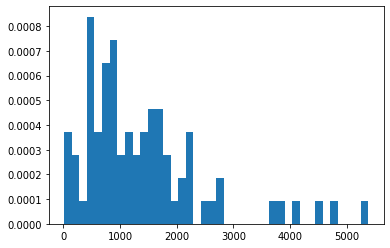

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(diferencias, density=True, bins=40)  # density=False would make counts

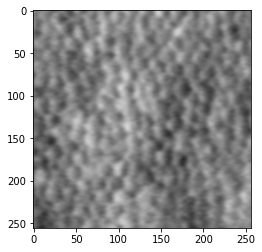

In [ ]:
plt.imshow(data[max])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


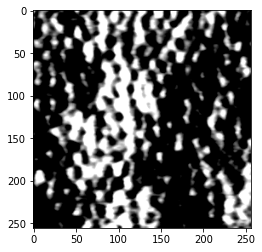

In [ ]:
plt.imshow(test_data[max])
plt.show()

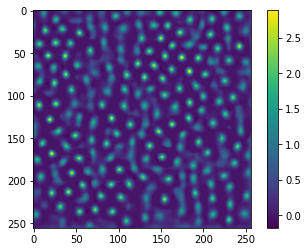

In [ ]:
plt.imshow(A[max][:,:,0])
plt.colorbar()
plt.show()

In [ ]:
np.sum(np.sum(A[max][:,:,0],0),0)/100

198.1759765625

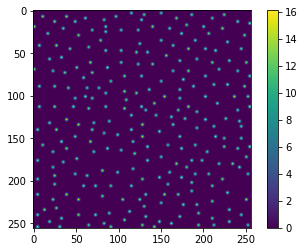

In [ ]:
plt.imshow(test_anno[max][:,:,0])
plt.colorbar()
plt.show()

In [ ]:
np.sum(np.sum(test_anno[max][:,:,0],0),0)/100

252.0

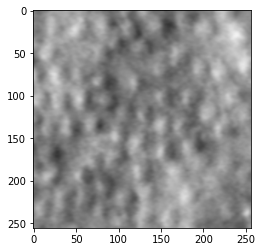

In [ ]:
plt.imshow(data[min])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


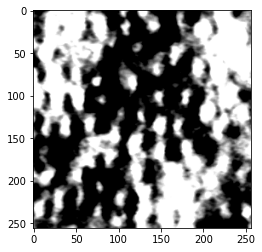

In [ ]:
plt.imshow(test_data[min])
plt.show()

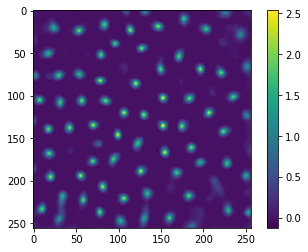

In [ ]:
plt.imshow(A[min][:,:,0])
plt.colorbar()
plt.show()

In [ ]:
np.sum(np.sum(A[min][:,:,0],0),0)/100

76.873857421875

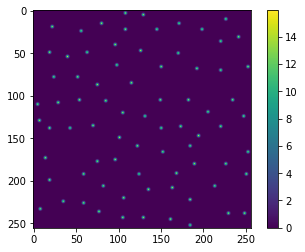

In [ ]:
plt.imshow(test_anno[min][:,:,0])
plt.colorbar()
plt.show()

In [ ]:
np.sum(np.sum(test_anno[min][:,:,0],0),0)/100

77.000009765625

# Con Train

In [ ]:
AAA = model.predict(train_data)
mean_diff = np.average(np.abs(np.sum(np.sum(AAA,1),1)-np.sum(np.sum(train_anno,1),1))) / (100.0)
print('After training, the difference is : {} cells per image.'.format(np.abs(mean_diff)))

After training, the difference is : 15.43799072265625 cells per image.


In [ ]:
train_pred = np.sum(np.sum(AAA,1),1)
train_true = np.sum(np.sum(train_anno,1),1)

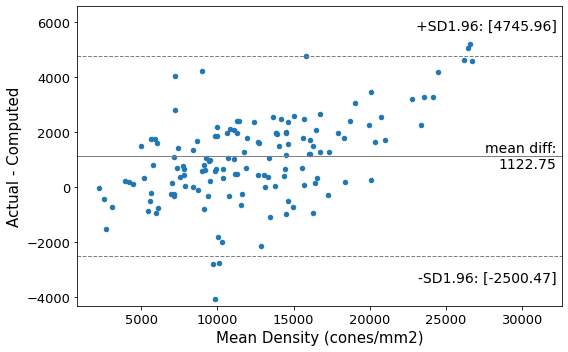

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(train_true, train_pred, ax = ax)
plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

# Con VAL

In [ ]:
AA = model.predict(val_data)
mean_diff = np.average(np.abs(np.sum(np.sum(AA,1),1)-np.sum(np.sum(val_anno,1),1))) / (100.0)
print('After training, the difference is : {} cells per image.'.format(np.abs(mean_diff)))

After training, the difference is : 12.631978759765625 cells per image.


In [ ]:
val_pred = np.sum(np.sum(AA,1),1)
val_true = np.sum(np.sum(val_anno,1),1)

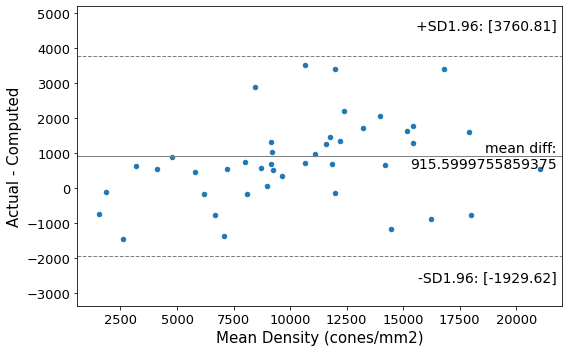

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(val_true, val_pred, ax = ax)
plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

Vamos a tratar de hacer regresion con esos datos

In [ ]:
X_train = train_pred
y_train = train_true

In [ ]:
X_train.shape, y_train.shape

((140, 1), (140, 1))

In [ ]:
X_val = val_pred
y_val = val_true

In [ ]:
X_val.shape, y_val.shape

((44, 1), (44, 1))

In [ ]:
X_test = pred
y_test = true

In [ ]:
X_test.shape, y_test.shape

((80, 1), (80, 1))

In [ ]:
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.preprocessing import MinMaxScaler

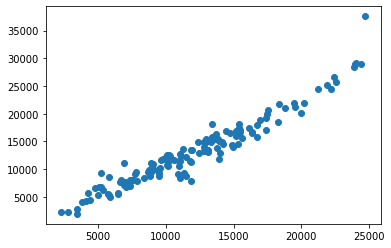

In [ ]:
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.scatter(X_train, y_train)
plt.show()

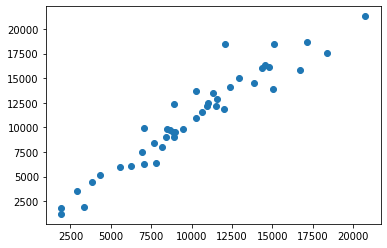

In [ ]:
plt.scatter(X_val, y_val)
plt.show()

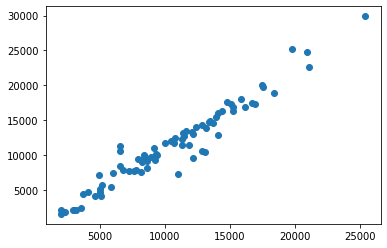

In [ ]:
plt.scatter(X_test, y_test)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
 reg.score(X_train, y_train)

0.9294298107068026

In [ ]:
reg.score(X_val, y_val)

0.9060941841326751

In [ ]:
reg.score(X_test, y_test)

0.9378667327841561

In [ ]:
new_pred = reg.predict(pred)

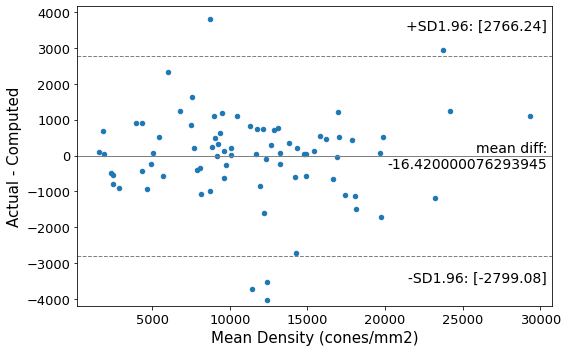

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(true, new_pred, ax = ax)
plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

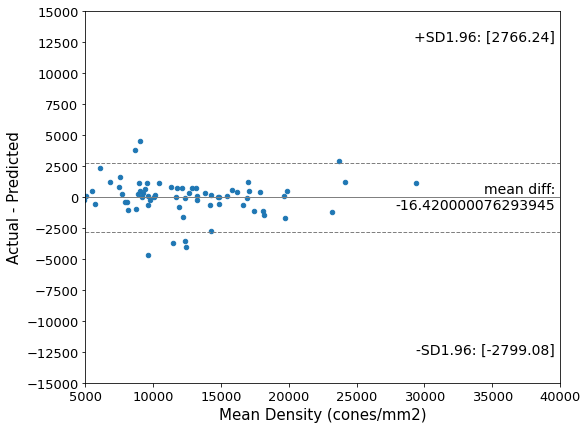

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,6))
sm.graphics.mean_diff_plot(true, new_pred, ax = ax)
plt.ylabel('Actual - Predicted')
plt.ylim(-15000, 15000)
plt.yticks(np.arange(-15000, 15000+1, 2500))
plt.xlabel('Mean Density (cones/mm2)')
plt.xlim(5000, 40000)
plt.show()

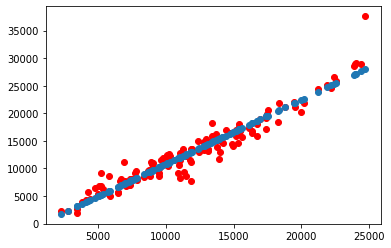

In [ ]:
plt.scatter(X_train, y_train, c = 'red')
plt.scatter(X_train, reg.predict(X_train))
plt.show()

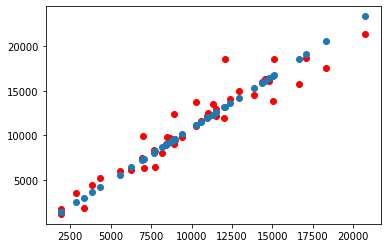

In [ ]:
plt.scatter(X_val, y_val, c = 'red')
plt.scatter(X_val, reg.predict(X_val))
plt.show()

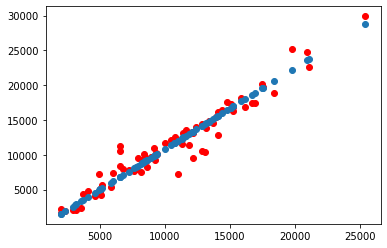

In [ ]:
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_test, new_pred)
plt.show()

In [ ]:
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [ ]:
y = y.ravel()

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters = {'kernel':['poly'], 'C':[0.0625,0.125,0.25,0.5,1,2,4,8], 'degree':[1,2,3,4,5,6]}
svr = SVR()
rgs = GridSearchCV(svr, parameters)
rgs.fit(X, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8],
                         'degree': [1, 2, 3, 4, 5, 6], 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
new_pred = rgs.predict(pred)

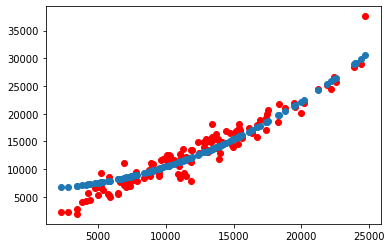

In [ ]:
plt.scatter(X_train, y_train, c = 'red')
plt.scatter(X_train, rgs.predict(X_train))
plt.show()

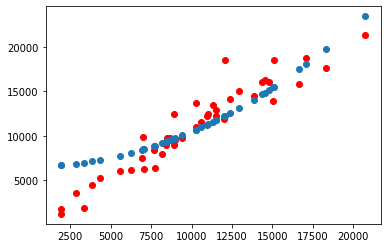

In [ ]:
plt.scatter(X_val, y_val, c = 'red')
plt.scatter(X_val, rgs.predict(X_val))
plt.show()

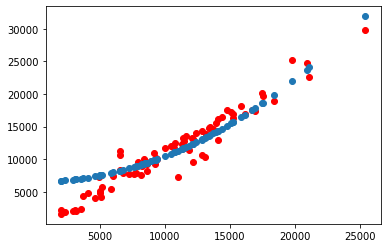

In [ ]:
plt.scatter(X_test, y_test, c = 'red')
plt.scatter(X_test, new_pred)
plt.show()

In [ ]:
true = true.ravel()

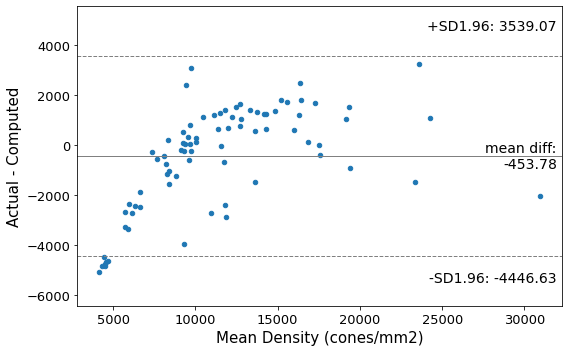

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(true, new_pred, ax = ax)
plt.ylabel('Actual - Computed')
plt.xlabel('Mean Density (cones/mm2)')
plt.show()

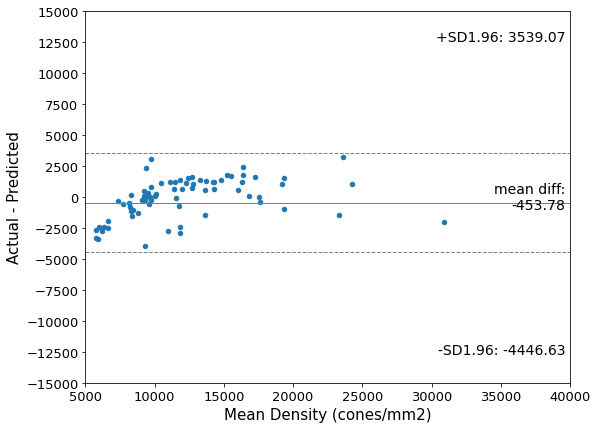

In [ ]:
import statsmodels.api as sm
f, ax = plt.subplots(1, figsize = (8,6))
sm.graphics.mean_diff_plot(true, new_pred, ax = ax)
plt.ylabel('Actual - Predicted')
plt.ylim(-15000, 15000)
plt.yticks(np.arange(-15000, 15000+1, 2500))
plt.xlabel('Mean Density (cones/mm2)')
plt.xlim(5000, 40000)
plt.show()